In [3]:
import numpy as np
import pandas as pd

from stratmanager import StrategyManager
import sklearn.mixture as mix
from ta.momentum import RSIIndicator
import matplotlib.pyplot as plt

### Data Extraction and Returns Overview

In [2]:
start_date = "2017-01-01"
end_date = "2022-06-01"
symbol = 'BTC-USD'

strat_mgr = StrategyManager(symbol, start_date, end_date)
df = strat_mgr.df.copy()
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets
Date,,,,,,,,
2017-01-02,998.617004,1031.390015,996.702026,1021.750000,222184992,0.023464,0.034803,0.023314
2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,185168000,0.021620,0.022005,0.045999
2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,344945984,0.106233,0.110130,0.159122
2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,510199008,-0.122410,0.308302,0.018098
2017-01-06,1014.239990,1046.810059,883.943970,902.200989,351876000,-0.109711,0.184249,-0.092307


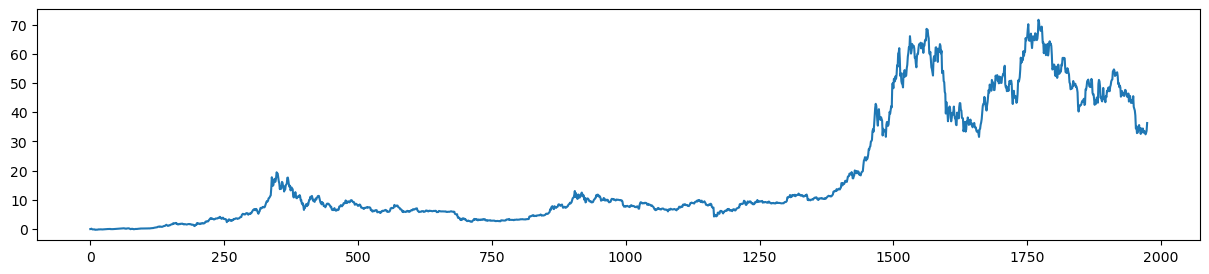

In [6]:
# Benchmark Returns Profile
fig = plt.figure(figsize=(15, 3))
plt.plot(df["Bench_C_Rets"].values)
plt.show()

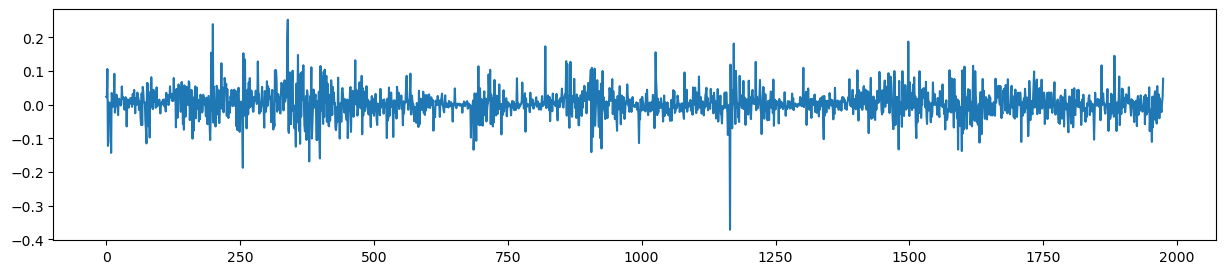

In [8]:
# Benchmark Returns Profile
fig = plt.figure(figsize=(15, 3))
plt.plot(df["Returns"].values)
plt.show()

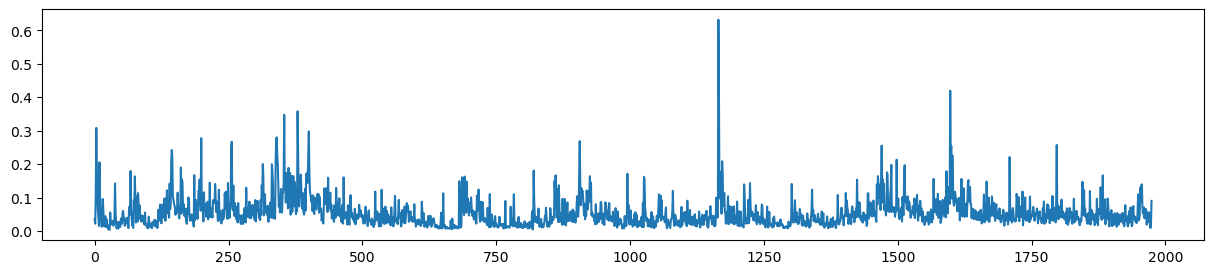

In [9]:
# Benchmark Returns Profile
fig = plt.figure(figsize=(15, 3))
plt.plot(df["Range"].values)
plt.show()

### Feature Engineering - Feature Expansion

In [11]:
# Create a copy
df_fe = df.copy()

### Indicators

In [12]:
# Add RSI
rsi = RSIIndicator(close=df_fe["Close"], window=14).rsi()
df_fe["RSI"] = rsi
df_fe["RSI_Ret"] = df_fe["RSI"] / df_fe["RSI"].shift(1)

In [14]:
# Add Moving Average
df_fe["MA_12"] = df_fe["Close"].rolling(window=12).mean()
df_fe["MA_21"] = df_fe["Close"].rolling(window=21).mean()

In [15]:
# Day of Week
df_fe["DOW"] = df_fe.index.day_of_week

In [16]:
# Rolling Cumulative Returns
df_fe["Roll_Rets"] = df_fe["Returns"].rolling(window=30).sum()

In [17]:
# Rolling CUmulative Range
df_fe["Avg_Range"] = df_fe["Range"].rolling(window=30).mean()

### Time interval

In [18]:
# Add Time Intervals
t_steps = [1, 2]

t_features = ["Returns", "Range", "RSI_Ret"]

for ts in t_steps:
    for tf in t_features:
        df_fe[f"{tf}_T{ts}"] = df_fe[tf].shift(ts)

In [19]:
df_fe.head(3)

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,MA_21,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-02,998.617004,1031.390015,996.702026,1021.750000,222184992,0.023464,0.034803,0.023314,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,185168000,0.021620,0.022005,0.045999,NaN,NaN,...,NaN,1,NaN,NaN,0.023464,0.034803,NaN,NaN,NaN,NaN
2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,344945984,0.106233,0.110130,0.159122,NaN,NaN,...,NaN,2,NaN,NaN,0.021620,0.022005,NaN,0.023464,0.034803,NaN


### Feature Engineering - Feature Scaling

In [22]:
# Correct for Stationarity
df_fs = df_fe.copy()
df_fs[["Open", "High", "Low", "Volume"]] = df_fs[["Open", "High", "Low", "Volume"]].pct_change()

### Assess Data for ML Readiness

In [24]:
# Check for NaN
df_fs.isnull().values.any()
df_fs.dropna(inplace = True)

In [25]:
# Check for inf Values
dfobj = df_fs.isin([np.inf, -np.inf])
count = np.isinf(dfobj).values.sum()

In [27]:
# Check for non-numerical objects
df_fs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1946 entries, 2017-01-31 to 2022-05-30
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1946 non-null   float64
 1   High          1946 non-null   float64
 2   Low           1946 non-null   float64
 3   Close         1946 non-null   float64
 4   Volume        1946 non-null   float64
 5   Returns       1946 non-null   float64
 6   Range         1946 non-null   float64
 7   Bench_C_Rets  1946 non-null   float64
 8   RSI           1946 non-null   float64
 9   RSI_Ret       1946 non-null   float64
 10  MA_12         1946 non-null   float64
 11  MA_21         1946 non-null   float64
 12  DOW           1946 non-null   int64  
 13  Roll_Rets     1946 non-null   float64
 14  Avg_Range     1946 non-null   float64
 15  Returns_T1    1946 non-null   float64
 16  Range_T1      1946 non-null   float64
 17  RSI_Ret_T1    1946 non-null   float64
 18  Returns_T2

In [28]:
# Describe DataFrame
df_fs.describe()

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,MA_21,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2
count,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,...,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000
mean,0.002640,0.002469,0.002669,17570.438400,0.034158,0.002681,0.054619,18.356974,53.353131,1.005225,...,17422.614146,3.000000,0.080488,0.054496,0.002642,0.054574,1.005097,0.002629,0.054565,1.005045
std,0.041294,0.036165,0.041674,17584.150825,0.285609,0.041337,0.045462,19.598884,14.536341,0.104682,...,17508.120701,2.000514,0.252338,0.024850,0.041303,0.045469,0.104531,0.041300,0.045477,0.104513
min,-0.365924,-0.263712,-0.364062,937.520020,-0.869188,-0.371695,0.004622,-0.044698,9.920239,0.453659,...,885.613522,0.000000,-0.844981,0.015818,-0.371695,0.003887,0.453659,-0.371695,0.003887,0.453659
25%,-0.015749,-0.012419,-0.012327,6306.479858,-0.122297,-0.015891,0.026312,5.905869,43.028897,0.954042,...,6417.694284,1.000000,-0.079972,0.036458,-0.015891,0.026289,0.954042,-0.015891,0.026289,0.954042
50%,0.002232,-0.000083,0.003320,9207.506836,-0.007011,0.002284,0.042897,8.902196,52.563634,1.006141,...,9214.705659,3.000000,0.052905,0.049081,0.002280,0.042881,1.005988,0.002250,0.042881,1.005823
75%,0.020769,0.016445,0.019541,31611.601562,0.145432,0.021156,0.067144,33.734586,63.296791,1.047744,...,32933.907064,5.000000,0.248645,0.067115,0.021105,0.067098,1.047471,0.021047,0.067098,1.047124
max,0.250461,0.245708,0.247892,67566.828125,5.439003,0.252472,0.631387,71.644966,94.302215,1.926078,...,63016.876488,6.000000,1.154731,0.138628,0.252472,0.631387,1.926078,0.252472,0.631387,1.926078


In [29]:
### Save Data
df_fs.to_csv(f"data/{symbol}.csv")